# Data Cleaning & Visualization

In [ ]:
!pip install ray
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.1 MB 7.1 MB/s 
     |████████████████████████████████| 8.8 MB 48.2 MB/s 
     |████████████████████████████████| 468 kB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 32.3 MB/s 


In [ ]:
import gdown

url = 'https://drive.google.com/drive/u/1/folders/15s4q-UX-OffTIxU_y0Y06SPYynXQmQxS'

gdown.download_folder(url)

Retrieving folder list


Processing file 1-6xgAzSmaXipj9CJi68JcE86IbbyvXrr data_debug.csv
Processing file 1-3gTltnv96HPVXyumbw9hT9BU6tgHgv8 data_debug.pkl
Processing file 1NfYu_1WV42evrmDEbGEPpSfNkhIeK8lv data_full_clean.csv
Processing file 1-4W7hE3EERAOJ0ocu7KPS8qzBbI5eDhI data_full.csv
Processing file 1--gL9W3Y9Oclw1BFxaTukCTuIHuQKTnj data_full.pkl
Processing file 1qD3yo05Es8T-aGjJQatVdAREtF-V82_R DATA-FULL from Zhicong.zip
Retrieving folder 1jSW5PpVXPiU6dEP18fmZZ0_b08cS_CHb Raw data
Processing file 1Lv10vWW2bpzhj3nKJou7MvAyTQBcvPIP 20210101-20221026 MISO Actual Energy Price.csv
Processing file 1kY7lZNcMuq_vWOJvAI6edtEVJm4sA5tS 20210101-20221026 MISO Day-Ahead Energy Price.csv
Processing file 1iNmC7b_KTV2oIUOlnHBQs6vUzoN3fMKi 20210101-20221026 MISO Forecasted Load.csv
Processing file 1Qj7N94FI6lkBoEH6nH_KWROed-dtkE1k 20210101-20221026 weather.csv
Processing file 1piBnR0jpb0kB4MgdAP3Dg-H_ur7MWITs 20221001-20221026 MISO Actual Energy Price.csv
Processing file 1Lc1KWJWR-6niPlTdnGs0nSrnkhjLpGaZ 20221001-20221026

Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1-6xgAzSmaXipj9CJi68JcE86IbbyvXrr
To: /content/data_debug.csv
100%|██████████| 91.2k/91.2k [00:00<00:00, 36.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3gTltnv96HPVXyumbw9hT9BU6tgHgv8
To: /content/data_debug.pkl
100%|██████████| 177k/177k [00:00<00:00, 50.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NfYu_1WV42evrmDEbGEPpSfNkhIeK8lv
To: /content/data_full_clean.csv
100%|██████████| 1.97M/1.97M [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4W7hE3EERAOJ0ocu7KPS8qzBbI5eDhI
To: /content/data_full.csv
100%|██████████| 2.36M/2.36M [00:00<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--gL9W3Y9Oclw1BFxaTukCTuIHuQKTnj
To: /content/data_full.pkl
100%|██████████| 4.47M/4.47M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qD3yo05Es8T-aGjJQatVdAREtF-V82_R
To: /content/DATA-F

['/content/data_debug.csv',
 '/content/data_debug.pkl',
 '/content/data_full_clean.csv',
 '/content/data_full.csv',
 '/content/data_full.pkl',
 '/content/DATA-FULL from Zhicong.zip',
 '/content/20210101-20221026 MISO Actual Energy Price.csv',
 '/content/20210101-20221026 MISO Day-Ahead Energy Price.csv',
 '/content/20210101-20221026 MISO Forecasted Load.csv',
 '/content/20210101-20221026 weather.csv',
 '/content/20221001-20221026 MISO Actual Energy Price.csv',
 '/content/20221001-20221026 MISO Day-Ahead Energy Price.csv',
 '/content/20221001-20221026 MISO Forecasted Load.csv',
 '/content/20221001-20221026 weather.csv']

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import KFold
import torch
from torch import nn,optim
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
# Grid Search
from functools import partial
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_features = 32


class LMPDataset(torch.utils.data.Dataset):
    def __init__(self, Data, Label, length=50, hop=25):
        self.length = length
        self.hop = hop
        self.Data = Data.astype(np.float32)
        if Label.ndim==1:
            self.Label = np.expand_dims(Label, 0).astype(np.float32).reshape(-1,1)
        else:
            self.Label = Label.astype(np.float32).reshape(-1,1)

    def __len__(self):
        return ((self.Data.shape[0]-self.length) // self.hop) + 1

    def __getitem__(self, idx):
        data_tensor = torch.tensor(self.Data[idx*self.hop:idx*self.hop+self.length])
        label_tensor = torch.tensor(self.Label[idx*self.hop:idx*self.hop+self.length])
        return data_tensor, label_tensor


def prep_rnn_data(df, batch_size=64, train=0.7, val=0.15):
    dat = df.to_numpy()
    n = dat.shape[0]
    n_train = int(n*train)
    n_val = int(n*val)

    feature_scaler = preprocessing.MinMaxScaler()
    label_scaler = preprocessing.MinMaxScaler()
    feature = df.iloc[:n_train,:-1]
    label = df.iloc[:n_train,-1]
    feature_scaler = feature_scaler.fit(feature.to_numpy())
    label_scaler = label_scaler.fit(np.expand_dims(label,axis=1))
    
    def prep_loader(start, end, shuffle=False):
        feature, label = dat[start:end, :-1], dat[start:end, -1:]
        feature, label = feature_scaler.transform(feature), label_scaler.transform(label)
        dataset = LMPDataset(feature, label)
        return torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle)
    
    return (prep_loader(0, n_train, True), 
            prep_loader(n_train, n_train+n_val), 
            prep_loader(n_train+n_val, n), 
            label_scaler)
    
class LSTM(nn.Module):
    def __init__(self, hidden_size=512, n_layers=5):
        super().__init__()
        self.lstm = nn.LSTM(32, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input_seq):
        input_seq = input_seq.transpose(0, 1)
        # length, n_batch, h_in
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out)
        return predictions.transpose(0, 1)
def test_load_dat():
    # Load data and model configurations
    os.chdir('/content')
    df = pd.read_csv('data_full_clean.csv')
    train_loader, vali_loader, _, _ = prep_rnn_data(df)
test_load_dat()

In [ ]:
def train_with_ray(config):
    # Load data and model configurations
    os.chdir('/content')
    df = pd.read_csv('data_full_clean.csv')
    train_loader, vali_loader, _, _ = prep_rnn_data(df)

    model = LSTM(config["hidden_size"],config["n_layers"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model = model.to(device)

    mse_loss = torch.nn.MSELoss()
    criterion = lambda x, y: mse_loss(x, y)
    if config["optimizer_name"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    # Total epochs number is set to 500.
    epochs = 300
    train_losses=[]
    vali_losses=[]
    early_stop_patience = 20 # early stop
    for epoch in range(epochs):
        train_epoch_loss = 0
        vali_epoch_loss=0
        # Training
        model.train()
        for batch_feature, batch_label in train_loader:
            batch_feature = batch_feature.to(device)
            batch_label = batch_label.to(device)
            optimizer.zero_grad()
            prediction = model(batch_feature)
            loss = criterion(prediction, batch_label)
            if epoch>0:
                loss.backward()
                optimizer.step()
            train_epoch_loss += loss.item()
        train_losses.append(train_epoch_loss/len(train_loader))
        # Validation
        model.eval()
        with torch.no_grad():
            for batch_feature, batch_label in vali_loader:
                batch_feature = batch_feature.to(device)
                batch_label = batch_label.to(device)
                prediction = model(batch_feature)
                loss = criterion(prediction, batch_label)
                vali_epoch_loss += loss.item()
            vali_losses.append(vali_epoch_loss/len(vali_loader))
        if len(vali_losses) >= early_stop_patience:
            if vali_losses[-early_stop_patience] == min(
                vali_losses[-early_stop_patience:]):
                break
        # Save checkpoints
        os.makedirs("lstm_model", exist_ok=True)
        torch.save((model.state_dict(), optimizer.state_dict()), 
                  "lstm_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("lstm_model")
    session.report({"loss": vali_epoch_loss/len(vali_loader)},
                  checkpoint=checkpoint)
    print("Finished Training")



In [ ]:
def main(num_samples=3, max_time=100, gpus_per_trial=1):
    # Hyperparameter pool
    config = {
        "batch_size": tune.choice([128, 256, 512]),
        "hidden_size": tune.choice([2**i for i in range(7,11)]),
        "n_layers": tune.choice([1,2,3]),
        "optimizer_name": tune.choice(["SGD","ADAM"]),
        "lr": tune.choice([10**(-i) for i in range(1,5)])
    }
    scheduler = ASHAScheduler(
        max_t=max_time,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_with_ray),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))

    return best_result
      
best_result = main(num_samples=20, max_time=300, gpus_per_trial=1)

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_with_ray_c960f_00000,2022-11-30_05-49-51,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00789705,172.28.0.2,2918,True,4.52017,4.52017,4.52017,1669787391,0,,1,c960f_00000,0.00388265
train_with_ray_c960f_00001,2022-11-30_05-49-52,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00782604,172.28.0.2,2918,True,0.636143,0.636143,0.636143,1669787392,0,,1,c960f_00001,0.00388265
train_with_ray_c960f_00002,2022-11-30_05-50-06,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.0083628,172.28.0.2,2918,True,14.2004,14.2004,14.2004,1669787406,0,,1,c960f_00002,0.00388265
train_with_ray_c960f_00003,2022-11-30_05-50-08,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00821144,172.28.0.2,2918,True,1.78198,1.78198,1.78198,1669787408,0,,1,c960f_00003,0.00388265
train_with_ray_c960f_00004,2022-11-30_05-50-18,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00140823,172.28.0.2,2918,True,9.44229,9.44229,9.44229,1669787418,0,,1,c960f_00004,0.00388265
train_with_ray_c960f_00005,2022-11-30_05-50-29,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00785778,172.28.0.2,2918,True,10.9431,10.9431,10.9431,1669787429,0,,1,c960f_00005,0.00388265
train_with_ray_c960f_00006,2022-11-30_05-50-33,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00744785,172.28.0.2,2918,True,3.85977,3.85977,3.85977,1669787433,0,,1,c960f_00006,0.00388265
train_with_ray_c960f_00007,2022-11-30_05-51-06,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00813631,172.28.0.2,2918,True,32.9694,32.9694,32.9694,1669787466,0,,1,c960f_00007,0.00388265
train_with_ray_c960f_00008,2022-11-30_05-51-21,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.0073638,172.28.0.2,2918,True,15.8296,15.8296,15.8296,1669787481,0,,1,c960f_00008,0.00388265
train_with_ray_c960f_00009,2022-11-30_05-52-02,True,,69ac43dfd26443988b9031932e3e1c64,e81853eda200,1,0.00783084,172.28.0.2,2918,True,40.6392,40.6392,40.6392,1669787522,0,,1,c960f_00009,0.00388265


(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training
(train_with_ray pid=2918) Finished Training


2022-11-30 06:04:07,523	INFO tune.py:778 -- Total run time: 864.98 seconds (864.74 seconds for the tuning loop).


Best trial config: {'batch_size': 256, 'hidden_size': 512, 'n_layers': 1, 'optimizer_name': 'ADAM', 'lr': 0.001}
Best trial final validation loss: 0.0005897059163544327


Best model actual loss: 370.66790771484375


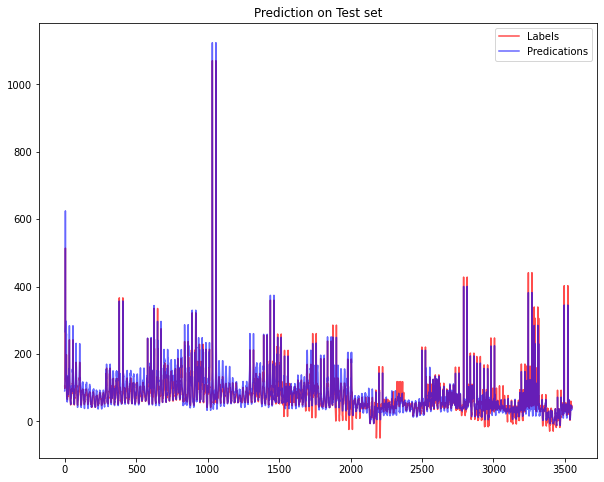

In [ ]:
def test_best_model_norm(best_result):
    # Load configuration of model with best performance
    best_trained_model = LSTM(
        best_result.config["hidden_size"],
        best_result.config["n_layers"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model = best_trained_model.to(device)

    checkpoint_path = os.path.join(
        best_result.checkpoint.to_directory(),
        "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)
    # Notice that labels are denormalized, the torch MSE 
    # is not applicable, so the criterion is hard-coded.
    criterion = lambda x, y: ((x-y)**2).mean()

    os.chdir('/content')
    df = pd.read_csv('data_full_clean.csv')
    train_loader,vali_loader,test_loader,y_scaler = prep_rnn_data(df)

    epoch_loss=0
    predictions=[]
    labels = []
    for feature,label in test_loader:
        feature = feature.to(device)
        label = label.to(device)
        prediction = best_trained_model(feature)
        # Denormalize label and prediction 
        # so that the loss is shown with actual MSE.
        label = y_scaler.inverse_transform(label.cpu().numpy().reshape(-1, 1))
        prediction = y_scaler.inverse_transform(
            prediction.detach().cpu().numpy().reshape(-1, 1))
        loss = criterion(prediction, label)
        epoch_loss += loss.item()
        labels.extend(label.squeeze())
        predictions.extend(prediction.squeeze())

    print("Best model actual loss: {}".format(epoch_loss/len(test_loader)))

    rcParams['figure.figsize'] = 10,8
    plt.plot(labels,label='Labels',alpha=.7,color='r')
    plt.plot(predictions,label="Predications",color='blue',alpha=.6)
    plt.title("Prediction on Test set" )
    plt.legend()
    plt.show()
test_best_model_norm(best_result)

## Report
1. Optimizer: Using the grid search, we found that the best optimizer is adam, since the lowest two losses are both produced by adam within similar training total time.

2. Batch Size: Through the grid search, for adam optimizer, we can see that larger batch size we had, the worse training loss we would get. The best batch size we could have is 256.

3. Other Hyperparameters: The hidden layer size plays a significant role in this play. In both cases for SGD and adam optimizers, if we have too large hidden layer size, the training time would drastically increase, and however, we could not get better results. The best tried hidden layer size is 512.
